In [1]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import rcParams
default_font = 12
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange', 'grey'] #rew #nrew #rew_test #nrew_test #GI

In [3]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
all_sessions = VG11 + VG14 + VG15
all_sessions

[{'mname': 'VG11', 'datexp': '2024_10_31', 'blk': '2'},
 {'mname': 'VG11', 'datexp': '2024_11_14', 'blk': '2'},
 {'mname': 'VG14', 'datexp': '2024_11_21', 'blk': '2'},
 {'mname': 'VG15', 'datexp': '2024_10_31', 'blk': '2'}]

In [52]:
def compute_speed(frameselector):
    frameselector = frameselector.assign(speed = 0)
    for trial_no in frameselector["trial_no"].unique():
        trial_inf = frameselector.query(f"trial_no == {trial_no}")
        dt = trial_inf["time_within_trial"].diff().shift(-1)
        ddistance = trial_inf["distance"].diff().shift(-1)
        last_dd = ddistance.iloc[-2]
        last_dt = dt.iloc[-2]
        dt = dt.fillna(last_dt)
        ddistance = ddistance.fillna(last_dd)
        frameselector.loc[frameselector["trial_no"] == trial_no, "speed"] = ddistance / dt
    return frameselector

def get_interp_speed(m1):
    #compute speed
    m1.frameselector = compute_speed(m1.frameselector)
    ntrials = m1.frameselector["trial_no"].astype(int).max()
    speed_interp = np.empty((ntrials, 400))
    #interp speed to 400 positions
    for trial_no in m1.frameselector["trial_no"].unique():
        trial_no = int(trial_no)
        trial_speed = m1.frameselector.query(f"trial_no == {trial_no}")["speed"].values
        trial_distance = m1.frameselector.query(f"trial_no == {trial_no}")["distance"].values
        if (trial_distance[0] > 0) & (trial_no > 1):
            previous_trial_speed = m1.frameselector.query(f"trial_no == {trial_no-1}")["speed"].values[-1]
            #append 0 to the beginning
            trial_distance = np.insert(trial_distance, 0, 0)
            trial_speed = np.insert(trial_speed, 0, previous_trial_speed)
        elif (trial_distance[0] > 0) & (trial_no == 1):
            trial_distance = np.insert(trial_distance, 0, 0)
            trial_speed = np.insert(trial_speed, 0, trial_speed[0])
        trial_distance = np.round(trial_distance, 0).astype(int)
        speed_interp[trial_no-1] = np.interp(np.arange(400), trial_distance, trial_speed)
    return speed_interp

In [53]:
mean_speed_per_trial_type_andlick = np.empty((len(all_sessions), 4, 2, 400)) # animals, trial types, lick/no lick, 400 positions
from pathlib import Path
for iss, sess in enumerate(all_sessions):
    name = sess['mname']
    date = sess['datexp']
    blk = sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj")
    speed_interp = get_interp_speed(m1)
    main_dir = Path(f"../data/{name}/{date}/{blk}")
    if not main_dir.exists():
        main_dir.mkdir(parents=True)
    np.save(main_dir / "speed_interp.npy", speed_interp)
    for it, (ttype, trials) in enumerate(m1.trial_dict.items()):
        t_licks, t_no_licks = utils.get_trials_with_licks(m1, lick_window=(150,250), trialtype=ttype)
        mean_licks = np.mean(speed_interp[t_licks], axis=0)
        mean_no_licks = np.mean(speed_interp[t_no_licks], axis=0)
        mean_speed_per_trial_type_andlick[iss, it, 0] =  mean_licks
        mean_speed_per_trial_type_andlick[iss, it, 1] =  mean_no_licks
np.save("../data/overall/mean_speed_per_trial_type_andlick.npy", mean_speed_per_trial_type_andlick)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG11\2024_11_14\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
Checking if model object exists ...
Loading mouse object from D:\mouseobj\VG14\2024_11_21\2
Existing mouse object has the following attr

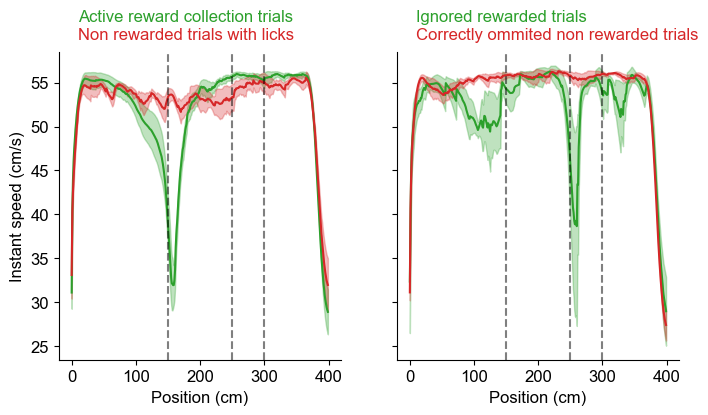

In [94]:
from scipy.stats import sem
cat_a = mean_speed_per_trial_type_andlick[:,[0,2],:].mean(1)
cat_b = mean_speed_per_trial_type_andlick[:,[1,3],:].mean(1)
rew_gran_mean = cat_a.mean(axis=0)
rew_gran_sem = sem(cat_a, axis=0)
nrew_gran_mean = cat_b.mean(axis=0)
nrew_gran_sem = sem(cat_b, axis=0)
fig, ax = plt.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].plot(rew_gran_mean[0], label=ttype, color='tab:green')
ax[0].fill_between(np.arange(400), rew_gran_mean[0]-rew_gran_sem[0], rew_gran_mean[0]+rew_gran_sem[0], alpha=0.3, color='tab:green')
ax[0].plot(nrew_gran_mean[0], label=ttype, color='tab:red')
ax[0].fill_between(np.arange(400), nrew_gran_mean[0]-nrew_gran_sem[0], nrew_gran_mean[0]+nrew_gran_sem[0], alpha=0.3, color='tab:red')
ax[1].plot(rew_gran_mean[1], label=ttype, color='tab:green')
ax[1].fill_between(np.arange(400), rew_gran_mean[1]-rew_gran_sem[1], rew_gran_mean[1]+rew_gran_sem[1], alpha=0.3, color='tab:green')
ax[1].plot(nrew_gran_mean[1], label=ttype, color='tab:red')
ax[1].fill_between(np.arange(400), nrew_gran_mean[1]-nrew_gran_sem[1], nrew_gran_mean[1]+nrew_gran_sem[1], alpha=0.3, color='tab:red')
ax[0].set_ylabel("Instant speed (cm/s)")
ax[0].text(10,62, "Active reward collection trials", color='tab:green')
ax[0].text(10,60, "Non rewarded trials with licks", color='tab:red')
ax[1].text(10,62, "Ignored rewarded trials", color='tab:green')
ax[1].text(10,60, "Correctly ommited non rewarded trials", color='tab:red')
for i in range(2):
    ax[i].set_xlabel("Position (cm)")
    ax[i].axvline(150, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(250, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(300, color='k', linestyle='--', alpha=0.5)

Ttest_relResult(statistic=0.3701107435054531, pvalue=0.7358854381590404)
Ttest_relResult(statistic=-1.620587898110738, pvalue=0.2035504778488603)


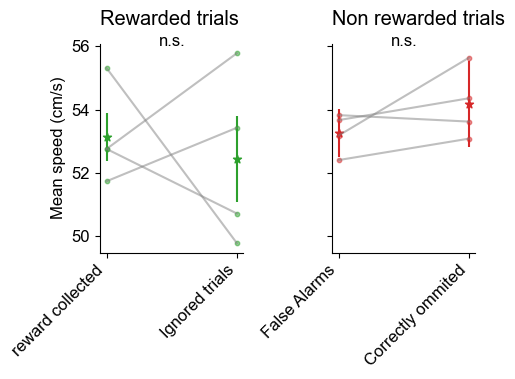

In [93]:
overall_speed_A = cat_a[:,:,0:125].mean(-1)
overall_speed_B = cat_b[:,:,0:125].mean(-1)
overall_speed_A_sem = sem(overall_speed_A, axis=0)
overall_speed_B_sem = sem(overall_speed_B, axis=0)

fig, ax = plt.subplots(1,2, figsize=(5, 4), sharey=True)
for animal in range(4):
    ax[0].scatter(0,overall_speed_A[animal,0], color='tab:green', label="Active reward collection", alpha=0.5, s=10)
    ax[0].scatter(1,overall_speed_A[animal,1],  color='tab:green', label="Ignored rewarded trials", alpha=0.5, s=10)
    ax[1].scatter(0,overall_speed_B[animal,0], color='tab:red', label="Non rewarded trials with licks", alpha=0.5, s=10)
    ax[1].scatter(1,overall_speed_B[animal,1], color='tab:red', label="Correctly ommited non rewarded trials",alpha=0.5, s=10)
ax[0].errorbar(0, overall_speed_A.mean(0)[0], yerr=overall_speed_A_sem[0], color='tab:green')
ax[0].scatter(0, overall_speed_A.mean(0)[0], marker='*', color='tab:green')
ax[0].errorbar(1, overall_speed_A.mean(0)[1], yerr=overall_speed_A_sem[1], color='tab:green')
ax[0].scatter(1, overall_speed_A.mean(0)[1], marker='*', color='tab:green')
ax[1].errorbar(0, overall_speed_B.mean(0)[0], yerr=overall_speed_A_sem[0], color='tab:red')
ax[1].scatter(0, overall_speed_B.mean(0)[0], marker='*', color='tab:red')
ax[1].errorbar(1, overall_speed_B.mean(0)[1], yerr=overall_speed_A_sem[1], color='tab:red')
ax[1].scatter(1, overall_speed_B.mean(0)[1], marker='*', color='tab:red')
ax[0].set_ylabel("Mean speed (cm/s)")
ax[0].set_title("Rewarded trials", y=1.05)
ax[1].set_title("Non rewarded trials", y=1.05)
ax[0].set_xticks([0,1], ["reward collected", "Ignored trials"], rotation=45, ha='right');
ax[1].set_xticks([0,1], ["False Alarms", "Correctly ommited"], rotation=45, ha='right');
# connect dots 
for animal in range(4):
    ax[0].plot([0,1], [overall_speed_A[animal,0], overall_speed_A[animal,1]], color='grey', alpha=0.5)
    ax[1].plot([0,1], [overall_speed_B[animal,0], overall_speed_B[animal,1]], color='grey', alpha=0.5)
ax[0].text(0.4, 56, "n.s.")
ax[1].text(0.4, 56, "n.s.")
plt.tight_layout()
# compute the paired ttest between the two conditions
from scipy.stats import ttest_rel
print(ttest_rel(overall_speed_A[:,0], overall_speed_A[:,1]))
print(ttest_rel(overall_speed_B[:,0], overall_speed_B[:,1]))



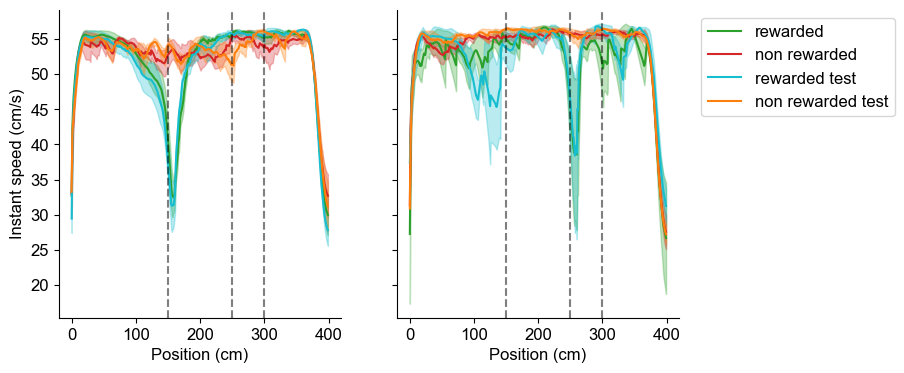

In [91]:
from scipy.stats import sem
grand_mean = np.mean(mean_speed_per_trial_type_andlick, axis=0)
gsem = sem(mean_speed_per_trial_type_andlick, axis=0)
fig, ax = plt.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
for it, ttype in enumerate(m1.trial_dict.keys()):
    ax[0].plot(grand_mean[it, 0], label=ttype, color=trial_type_palette[it])
    ax[0].fill_between(np.arange(400), grand_mean[it, 0]-gsem[it, 0], grand_mean[it, 0]+gsem[it, 0], alpha=0.3, color=trial_type_palette[it])
    ax[1].plot(grand_mean[it, 1], label=ttype, color=trial_type_palette[it])
    ax[1].fill_between(np.arange(400), grand_mean[it, 1]-gsem[it, 1], grand_mean[it, 1]+gsem[it, 1], alpha=0.3, color=trial_type_palette[it])
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_ylabel("Instant speed (cm/s)")
for i in range(2):
    ax[i].set_xlabel("Position (cm)")
    ax[i].axvline(150, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(250, color='k', linestyle='--', alpha=0.5)
    ax[i].axvline(300, color='k', linestyle='--', alpha=0.5)